In [13]:
%matplotlib inline
import matplotlib.pyplot as plt
import h5py as h5
import numpy as np
import dask
import dask.array as da
from PIL import Image
import glob

In [14]:
import os  # library to get directory and file paths
import tarfile # this module makes possible to read and write tar archives

def extract_data(src, dest):
    datadir = os.path.join(dest)
    if not os.path.exists(datadir):
        print("Extracting data...")
        tar_path = os.path.join(src+'.tgz')
        with tarfile.open(tar_path, mode='r:gz') as data:
            data.extractall(dest)
         
extract_data('fvalues','data') 

In [15]:
filenames = sorted(glob.glob("data/f*.h5"))
filenames[:5]

['data/f0001-values.h5',
 'data/f0002-values.h5',
 'data/f0003-values.h5',
 'data/f0004-values.h5',
 'data/f0005-values.h5']

In [16]:
f = h5.File("data/f0499-values.h5", "r")

In [17]:
list(f.keys())

['values']

In [18]:
f.get("values")

<HDF5 dataset "values": shape (257, 257), type "<f8">

In [19]:
g = h5.File("polar-mesh.h5", "r")
x = g.get('x')
g = h5.File("polar-mesh.h5", "r")
y = g.get('y')

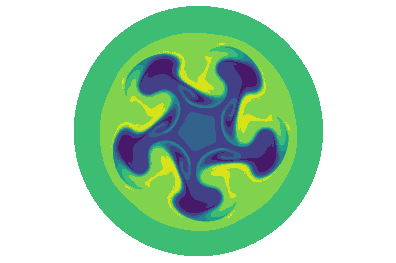

In [20]:
z = f.get("values")
plt.contourf(x, y, z)
plt.axis('equal')
plt.tight_layout()
plt.axis('off');

In [21]:
def save_plot( fn ):
    with h5.File(fn, "r") as f:
        dataset = "values"
        z = f.get(dataset)
        plt.contourf(x, y, z)
        plt.axis('equal')
        plt.tight_layout()
        plt.axis('off')
        plt.savefig(fn[-2:]+"png")
        plt.close()

In [22]:
from tqdm.notebook import tqdm
from time import time

tinit = time()

for fn in tqdm(filenames):
    save_plot(fn)
    
serial_time = time()-tinit

In [23]:
from concurrent.futures import ProcessPoolExecutor

tinit = time()

with ProcessPoolExecutor(4) as pool:
    pool.map(save_plot, filenames)

parallel_time = time() - tinit

In [24]:
serial_time / (4 * parallel_time) * 100 

40.15887491897121

In [25]:
def scale(x) :
    return np.uint8(255*(x-np.min(x)) / (np.max(x)-np.min(x)))



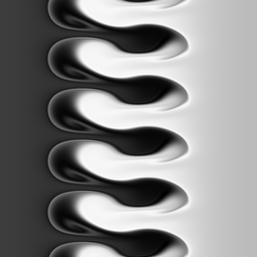

In [26]:
def plot_image( fn ):
    with h5.File(fn, "r") as f:
        dataset = "values"
        z = f.get(dataset)
        return Image.fromarray(scale(z))

plot_image(filenames[499])

In [27]:
from tqdm.notebook import tqdm
from PIL import Image

def create_image(fn):
    with h5.File(fn, "r") as f:
        dataset = "values"
        Z = f.get(dataset)
        return scale(Z)

def create_frames(filenames):

    return [create_image(fn) for fn in tqdm(filenames)]
    
frames = create_frames(filenames)

In [28]:
from ipywidgets import interact, IntSlider 
    
interact(lambda iframe: Image.fromarray(frames[iframe]), 
         iframe=IntSlider(min=0,
                          max=len(frames)-1,
                          step=1,
                          value=0, 
                          continuous_update=True))

interactive(children=(IntSlider(value=0, description='iframe', max=999), Output()), _dom_classes=('widget-inte…

<function __main__.<lambda>(iframe)>

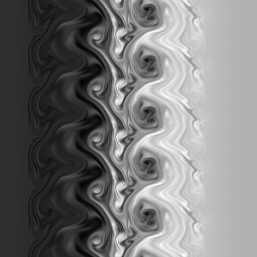

In [34]:
@dask.delayed
def read_frame(fn):
    with h5.File(fn, 'r') as f:
        d = f.get("values")[()]
        return scale(d)
    
read_frame(filenames[500])

def display_frame(array):
    return Image.fromarray(array)

display_frame(read_frame(filenames[-1]).compute())

In [35]:
dask_arrays = []
for fn in filenames:
    array = da.from_delayed(read_frame(fn), 
                            shape=(257,257), dtype=np.uint8)
    dask_arrays.append(array)

values = da.stack(dask_arrays)  # concatenate arrays along first axis

In [36]:
values

,Array,Chunk
Bytes,66.05 MB,66.05 kB
Shape,"(1000, 257, 257)","(1, 257, 257)"
Count,3000 Tasks,1000 Chunks
Type,uint8,numpy.ndarray


In [37]:
values = values.rechunk((1000,257,257))

In [38]:
display(values[-1,:,:].compute())

array([[ 49,  49,  48, ..., 176, 176, 176],
       [ 49,  49,  48, ..., 176, 176, 176],
       [ 49,  49,  48, ..., 176, 176, 176],
       ...,
       [ 49,  49,  48, ..., 176, 176, 176],
       [ 49,  49,  48, ..., 176, 176, 176],
       [ 49,  49,  48, ..., 176, 176, 176]], dtype=uint8)

In [41]:
import pandas as pd

df = pd.read_excel("Folds5x2_pp.xlsx", sheet_name=None)

In [42]:
type(df)

collections.OrderedDict

In [43]:
import numpy as np

class DataFrame:
    
    def __init__(self, filename):
        self.data = pd.read_excel(filename, 
                                    sheet_name=None, inferSchema='')
        self.sheets = self.data.keys()
        self.columns = self.data["Sheet1"].columns
        
    def select(self, var):
        return pd.concat( [self.data[sheet][var] for sheet in self.sheets] )
        
df = DataFrame('Folds5x2_pp.xlsx')
df.columns

Index(['AT', 'V', 'AP', 'RH', 'PE'], dtype='object')

In [44]:
%%time
results = {}

for a in df.columns:
    for b in df.columns:
        if a != b:
            results[a, b] = abs(df.select(a).corr(df.select(b)))
            
((a, b), corr) = max(results.items(), key=lambda kv: kv[1])
print(f"{a} matches with {b} with correlation {corr}")

AT matches with PE with correlation 0.9481284704167594
CPU times: user 51.9 ms, sys: 5.03 ms, total: 56.9 ms
Wall time: 58.8 ms


In [45]:
%%time

from concurrent.futures import ProcessPoolExecutor

e = ProcessPoolExecutor(4)

futures = {}

def corr( serie_a, serie_b):
    
    return abs(serie_a.corr(serie_b))

for a in df.columns:
    for b in df.columns:
        if a != b:
            futures[a, b] = e.submit( corr, df.select(a), df.select(b))
            
results = {k : f.result() for k, f in futures.items()}            

            
((a, b), corr) = max(results.items(), key=lambda kv: kv[1])
print(f"{a} matches with {b} with correlation {corr}")

AT matches with PE with correlation 0.9481284704167594
CPU times: user 99.8 ms, sys: 206 ms, total: 306 ms
Wall time: 353 ms
